In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle
from pandarallel import pandarallel

import mplh.cluster_help as ch

fig_utils from mplh


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
    use_small = snakemake.params.get("use_small", False)
    to_plots = snakemake.params.get("to_plots", True)
    don_dir = snakemake.input["don_dir"]
    outdir = snakemake.params["outdir"]

    params = snakemake.config["mt_as_clones"]["params"]
    af_ts = params["af_ts"]
    oth_af_ts = params["oth_af_ts"]
    cov_ts = params["cov_ts"]
    oth_cov_ts = params["oth_cov_ts"]
    num_cells = params["num_cells"]
    oth_num_cells = params["oth_num_cells"]
    mean_pos_cov = params["mean_pos_cov"]
    minClusterSize=params.get("minClusterSize", 3)
    d = snakemake.params["d"]

except NameError:
    use_small = False
    to_plots = True
    don_dir = ["/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0/",
               "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1/"]
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/mt_clones_thresh/scrap/donor0"
    d = 0
    af_ts = [0.01, 0.1, 0.16, 0.25, 0.4, 0.8, 0.95]
    oth_af_ts = [0.01, 0.1, 0.16, 0.25, 0.4, 0.8, 0.95]
    cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
    oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 
    num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
    oth_num_cells = [0.3, 0.4, 0.6, 0.8] # fraction is of cells with sufficient coverage
    mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position
    minClusterSize=3


In [4]:
ncpus=12

In [5]:
pandarallel.initialize(nb_workers=ncpus)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
objectives = ["n_vars_obs" , "n_cells_obs"] 
weights = [1,1]
param_objectives = ["cov", "oth_cov", "af", "oth_af", "ncells", "oth_ncells"]
param_weights = [1,1,1,-1,1,-1 ]
dendro_objectives = ["variant_coefficient_variation"]
dendro_weights = [1]
# dendro_objectives = ["obj_nclones_more_than_one_unique", 
#                      "variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                      "n_clones"]
# dendro_weights = [1,1, 1]

all_objectives = objectives+param_objectives+dendro_objectives
all_weights = weights+param_weights+dendro_weights

# all_objectives = objectives+param_objectives
# all_weights = weights+param_weights

all_weights

[1, 1, 1, 1, 1, -1, 1, -1, 1]

In [7]:
# There are 7 params to use for calling the clone
params = {"af":af_ts,
          "oth_af":oth_af_ts,
          "ncells": num_cells,
          "oth_ncells":oth_num_cells,
          "mean_cov": mean_pos_cov,
          "cov":cov_ts,
          "oth_cov":oth_cov_ts,
         }
param_names = params.keys()
full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())
print(full_params.shape)
full_params.head()

(62720, 7)


af  oth_af  ncells  oth_ncells  mean_cov  cov  oth_cov
0  0.01    0.01     5.0         0.3         0    2        2
1  0.01    0.01     5.0         0.3         0    2        5
2  0.01    0.01     5.0         0.3         0    2       10
3  0.01    0.01     5.0         0.3         0    2       30
4  0.01    0.01     5.0         0.3         0    5        2

In [8]:
# cells_dir = join(outdir, "cells")
# if not exists(cells_dir):
#     os.mkdir(cells_dir)

In [9]:
#samples = samples.split(",")

In [10]:
#don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(basename(dirname(x)).split("donor")[-1]):dirname(x) for x in don_dir} #donor{d}/af.tsv

don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1'}

In [11]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov, return_cells=True):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess ncells thresholds
    if thresholds["ncells"] < 1: #fraction of cells or total
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
        
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    if thresholds["oth_ncells"] < 1: # Fraction of the remaining population
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)-len(in_cells)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        if return_cells:
            return True, in_cells
        return True
    if return_cells:
        return False, []
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

In [12]:
def get_cells(af, cov, oth_af, oth_cov, position_af, position_cov):
    """ Gets cells and oth_cells that pass thresholds. Assumes position already passed.
    """
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > af) & (position_cov > cov)
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= oth_af) & (position_cov > oth_cov)
    # drop the cells
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    oth_cells = oth_bin_position_af_cov[oth_bin_position_af_cov].index
    return {"clone_cells": in_cells, "other_cells": oth_cells}

In [13]:
from src.clone_variants_optim import _objectives_dendro

from src.utils.dendro_clust import run_dynamic

from icecream import ic

### Approach:
1. for each parameter run evaluate_series
2. Create a df of mt-by-cells all as 0. 
3. Loop through each variant and run get_vars_and_cells . This takes one variant, the af and cov of that variant, and returns a dictionary of {v:[cells]}, where cells have the variant with right af and coverage 
4. The dictionary is used to fill in the binary df
5. After loop, remove cells and variants with all 0. 
6. create objective score df with weights and 0 as scores
6. Calculate nvars, ncells by the shape and add to objective
7. objectives_params: adds params objectives to the df
8. cluster with jaccard (issue for many 0's?) and run dynamic tree
9. run dendro_objectives, which uses many of the ones from the clone-vars-table.
10. Return the objectives_params, and the df (with the labels meta) if return_date=True.


In [14]:
import src.clone_variants_optim as optim

In [15]:
from src.clone_variants_optim import params_and_multi_str 
from src.clone_variants_optim import params_to_str

In [16]:
def create_dendro(df, minClusterSize=30):
    ic('df', df.head())
    clusters, link = run_dynamic(df, metric="jaccard", minClusterSize=minClusterSize)
    
    ic(clusters.head())
    return clusters.drop("ID", axis=1).groupby("labels").size(), clusters

def calc_objectives(df):
    return {"n_cells_obs": df.shape[0], "n_vars_obs": df.shape[1]}

def calc_param_objectives(val, params_objectives_l):
    obj_params = {}
    for p in params_objectives_l:
        obj_params[p] = val[p]
    return obj_params

def get_binary_df(val, curr_af, curr_cov):
    bin_df = pd.DataFrame(np.zeros(curr_af.shape), index=curr_af.index, columns=curr_af.columns).astype(bool)
    thresh = [val["af"], val["oth_af"], val["cov"], val["oth_cov"]]
    #c_vars_df = pd.DataFrame(index=curr_af.o)
    for c_var in curr_af.columns:
        #print('c_val', c_var)
        pos_af = curr_af[c_var]
        pos_cov = curr_cov[c_var]
        isVar, cells = get_vars(val, pos_af, pos_cov, return_cells=True)
        if isVar:
            bin_df.loc[cells, c_var] = True
    # create binarized mt-cell df and calculate the dendro objectives 
    print('before remove 0 filter', bin_df.shape)

    bin_df = bin_df.loc[~((bin_df==0).all(axis=1)), ~((bin_df==0).all(axis=0))]
    print('after', bin_df.shape)
    #params_results.loc[ind,"Variants"] = ";".join(curr_vars)
    return bin_df


def calc_cv_objective(bin_df):
    af_var = bin_df.var()
    af_mean = bin_df.mean()
    return {"cv": (af_var/af_mean).sum()}

def evaluate_series(val, curr_af, curr_cov, return_data=True, get_dendro="cv", minClusterSize=30):
    bin_df = get_binary_df(val, curr_af, curr_cov)
    obj_dendro = {}
    if get_dendro == "dynamic":
        clusters_df, clusters = create_dendro(bin_df, minClusterSize=minClusterSize)
        ic(clusters_df.head())
        #ic((clusters_df>1).sum())
    elif get_dendro == "cv":
        obj_dendro = calc_cv_objective(bin_df)
    ic(bin_df.shape)
    ic(bin_df.head())
    
    # Objectives for nvars and nclones
    obj_bin = calc_objectives(bin_df)
    ic(obj_bin)
    # Parameter objectives - max/min parameter values
    obj_params = calc_param_objectives(val, param_objectives)
    ic(obj_params)
    obj = {}
    for i in [obj_bin, obj_params, obj_dendro]:
        for o in i:
            obj[o] = i[o]
    if return_data:
        out = {"objectives":pd.Series(obj), "binary_df": bin_df}
        if get_dendro=="dynamic":
            out["dendro_clust_df"] = clusters_df
            out["dendro_clust_labels"] = clusters
        return out
    return pd.Series(obj)

In [17]:
# for d in don_dirs: 
#     print('d', d)
#     curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
#     if curr_af.shape[0] == 0:
#         continue
#     curr_cov_name = curr_cov.copy()   
#     curr_cov_name.index = "COV-" + curr_cov.index
#     curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

#     if use_small: 
#         curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
#         full_params_df = full_params.iloc[:100]
#     else:
#         full_params_df = full_params.copy()
#     #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
#     all_passed_vars = defaultdict(list)
#     params_results = full_params_df.copy()
#     params_results["Variants"] = None

In [18]:
#for d in don_dirs: 
curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
# if curr_af.shape[0] == 0:
#     continue
curr_cov_name = curr_cov.copy()   
curr_cov_name.index = "COV-" + curr_cov.index
curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)


<AxesSubplot:ylabel='Cell'>

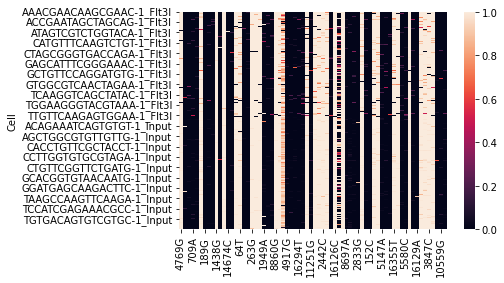

In [19]:
sns.heatmap(curr_af)

<AxesSubplot:ylabel='Cell'>

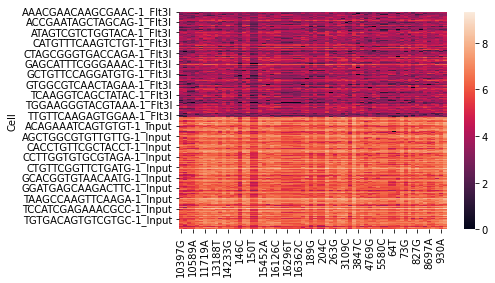

In [20]:
sns.heatmap(np.log2(curr_cov+1))

In [18]:

if use_small: 
    curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
    full_params_df = full_params.iloc[:100]
else:
    full_params_df = full_params.copy()

print('full_params_df', full_params_df.shape)

# results_df = full_params_df.sample(30).parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
# print((results_df>0).any())
# drop_inds = results_df.loc[(results_df==0).all(axis=1)].index
# results_norm = optim.set_multi(results_df, all_weights)
# rank_df = optim.set_multi_rank(results_norm, all_weights)

# drop_results = results_norm.loc[results_norm["multi"].isnull()]
# results_norm = results_norm.loc[~(results_norm["multi"].isnull())]

if full_params_df.shape[0]>=10000:
    results_df = full_params_df.sample(10000).parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
else:
    results_df = full_params_df.parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
#results_df = full_params.sample(100).parallel_apply(evaluate_series, args=(AF_df, DP_df, curr_labels), axis=1)

results_df.to_csv(join(outdir, "objectives.csv"))
full_params_df.to_csv(join(outdir, "raw_params.csv"))


#print(results_df.head())
print((results_df>0).any())
drop_inds = results_df.loc[(results_df==0).all(axis=1)].index



full_params_df (62720, 7)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (4992, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (5011, 23)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after before remove 0 filter(6984, 79) 
(7002, 196)
before remove 0 filter (7002, 196)
after (6978, 61)
after (697

after (5036, 63)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (7002, 30)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (7002,

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 62)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6984, 42)
before remove 0 filter (7002, 196)
after (116, 4)
before remove 0 filter (7002, 196)
after (4343, 34)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6983, 30)(7002, 196)

before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)
after (0, 0)after
 before remove 0 filter(7002, 29) 
(7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(6953, 13)
after (7002, 37)
before remove 0 filter (7002, 196)
after (3922, 39)
before remove 0 filter (7002, 196)
after (6981, 29)before remove 0 filter
 (7002, 196)
after (5014, 23)
b

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (6972, 18)before remove 0 filter
 (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 50)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter  (7002, 196)before remove 0 filter(7002, 196)
 
after (7002, 196)(6983, 30)

afterafter  (6984, 79)after(7002, 49)
 
(7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (7002, 29)(7002, 68)

before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (698, 37)(7002, 29)

before remove 

afterbefore remove 0 filter  (4293, 2)(7002, 196)

after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (4296, 13)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (109, 4)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (7002, 30)(7002, 49)

before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6986, 69)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (7002, 68)(7002, 30)

before remove 0 filter (7002, 196)
after (6976, 33)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after before remove 0 filterbefore remove 0 filter(7002, 29)  
(7002, 196)(7002, 196)

after (0, 0)
before remove 0 filter

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (0, 0)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (7002, 31)
before remove 0 filter (7002, 196)
after (4992, 29)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 39)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)af

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (5026, 39)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6975, 43)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (4992, 29)
(7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4261, 1)
after (7002, 29)
before remov

before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (5036, 63)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6983, 30)(7002, 196)

after (5026, 30)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filterafter  (7002, 196)(6972, 18)

after (4992, 29)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 38)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (5022, 30)
after (7002, 29)
before remove 0

before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (5036, 63)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (6975, 55)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (4261, 1)
(7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4977, 19)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6981, 29)after
 (7002, 31)
after (5014, 23)
before remove 0 filter (7002, 196)
after (7002, 30)
before remov

after (7002, 28)
after (7002, 30)
after (6953, 13)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterafter  (6981, 29)(7002, 29)

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4292, 10)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 79) 
(7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4261, 1)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
before remove 0 filter (7002, 196)after
 after(7002, 62) (4991, 28)

after (6981, 29)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 fi

before remove 0 filter (7002, 196)
after (6977, 45)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after after(5026, 30) 
(7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (6983, 30)before remove 0 filter
 (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (5026, 39)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
after (6979, 60)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4993, 34)
before remove 0 filter (7002, 196)
before remove

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remov

before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 68)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4289, 2)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (1685, 1)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (6984, 79)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (2011, 10)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter 

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (6973, 28)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 32)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 

before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4679, 5)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filterbefore remove 0 filter   (7002, 28)(7002, 196)(7002, 196)


after (0, 0)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6977, 23)
after (6974, 19)
before remove 0 fi

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 29)(7002, 196)

after (4263, 2)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filter (7002, 196)
after (6973, 25)
before remove 0 filter (7002, 196)
after before remove 0 filter(5022, 36) 
(7002, 196)
after (7002, 61)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6981, 29)after
 (6972, 18)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (

before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6976, 35)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 35)
after (7002, 89)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6984, 31)
before remove 0 filter (7002, 196)

before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6981, 29)
after (4289, 2)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 43)
before remove 0 filter (7002, 196)
after (4992, 34)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (0, 0)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filte

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4993, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter 
(7002, 196)
afterafter  (6984, 68)(4992, 29)

before remove 0 filter (7002, 196)
after (6984, 31)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (4261, 1)before remove 0 filter
 (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (4683, 11)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 196)after
 (5026, 38)
before remov

before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(6983, 30)

after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) (7002, 30)

after (7002, 68)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (4992, 33)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (7002, 79)
before remove 0 filter (7002, 196)
after (4292, 11)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)

after (5026, 39)
before remove 0 filter (7002, 196)
after (7002, 30)before remove 0 filter 
(7002, 196)
after (5036, 85)
before remove

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4260, 1)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5014, 23)before remove 0 filter
 (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 28)

before remove 0 filter (7002, 196)
after (6975, 57)
after (6983, 36)
before remove 0 filter (7002, 196)
before remove 0 f

before remove 0 filter (7002, 196)
after (4993, 34)
after (7002, 196)
before remove 0 filter (7002, 196)
after (1557, 1)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after after(7002, 28) 
(7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 62)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6954, 17)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filterafter  (7002, 196)(7002, 36)

after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(0, 0)
after (4295, 11)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (5064, 196)
b

after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

before remove 0 filterafter  (7002, 196)(7002, 68)

after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6968, 28)
before remove 0 filter (7002, 196)
after (1799, 1)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)before remove 0 filter
before remove 0 filter  (7002, 196)(7002, 196)

after after(6983, 30) (7002, 69)

after (6983, 36)
before remove 0 filterbefore remove 0 filter  (7

after (6983, 30)before remove 0 filter
 (7002, 196)
after (1799, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6984, 69)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6981, 29)
after (4502, 40)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 28)
befor

after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 30)
after (6968, 22)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 34)
after (7002, 58)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (6984, 68)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (4293, 2)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after 
(4292, 11)
after (6984, 71)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (1300, 5)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (7002, 

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 58)

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6984, 69)
after (4992, 34)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 69)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6984, 68)
after (6981, 29

before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 36)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 89)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filter (7002, 196)
after (6976, 23)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after (6980, 61)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 29)before remove 0 filter
 before remove 0 filter(7002, 196) 
(7002, 196)
after (1750, 1)
after (7002, 30)
after (6973, 37)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after(5064, 196) 
(7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002,

after (6973, 28)
before remove 0 filter (7002, 196)
after (6975, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter before remove 0 filter(7002, 196) (7002, 196)

after (7002, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6984, 31)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after after(7002, 30) 
(7002, 68)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (7002, 28)
after (7002, 50)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (0, 0)
after (7002, 41)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6977, 45)
before remove 0 filter (7002, 196)
after (5064, 196)
before rem

before remove 0 filter (7002, 196)
after (6975, 22)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
before remove 0 filter (7002, 196)
after (6984, 69)after
 (0, 0)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 79)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4292, 10)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (5036, 63)(7002, 36)

before remove 0 filt

before remove 0 filter (7002, 196)
after (5021, 29)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (5022, 36)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (7002, 36)(7002, 34)

before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 30)
after (7002, 79)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6973, 37)
after (7002, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filt

before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(4261, 1)
after (4343, 34)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (5026, 30)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 29)

after (6972, 18)
before remove 0 filter (7002, 196)
after (6972, 24)
before remove 0 filter (7002, 196)
after (4992, 34)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
af

before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter after (7002, 196) (7002, 196)
(4260, 1)

after (7002, 30)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 31)(7002, 196)

after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 68)
before remov

after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (5022, 36)
before remove 0 filter (7002, 196)
after (4471, 12)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6975, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after before

after (7002, 29)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6983, 30)after
 (7002, 28)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5036, 63)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4679, 5)
before remove 0 filter (7002, 196)
after (6976, 34)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6982, 30)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 79)
after (7002, 89)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (7002, 79)(7002, 36)

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 34)
after (7002, 33)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 35)
after (5022, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6954, 18)
before remov

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)after
 (7002, 28)
after (7002, 68)
before remove 0 filter (7002, 196)
after (5026, 38)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (7002, 29)(6971, 18)

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 37)(7002, 196)

after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (4261, 1)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove

after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (698, 37)
(4992, 33)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 68)(7002, 196)

after (6986, 68)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (6984, 41)
before remove 0 filter (7002, 196)
after (6975, 57)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 89)after
 (6984, 42)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4992, 33)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4292, 11)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002

before remove 0 filter (7002, 196)
after (4268, 3)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (6971, 18)(7002, 29)

before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after after(5026, 40) 
(6983, 30)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 79)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 51)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (4347, 39)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove

before remove 0 filter
 (7002, 196)after (331, 9)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 62)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (6973, 43)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4993, 30)
after (7002, 196)
before remove 0 filter before remove 0 filter(7002, 196) (7002, 196)

after (4260, 1)
after (7002, 89)
before remove 0 filter (7002, 196)
after (5036, 63)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (4977, 19)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 

before remove 0 filter (7002, 196)
after (6975, 22)
before remove 0 filter (7002, 196)
after (6980, 61)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after after(4992, 33) 
(7002, 30)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)before remove 0 filter
 (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 68)
after (5026, 43)
before remove 0 filter (7002, 196)
after (4977, 19)
before remove 0 filter (7002, 196)
after (6976, 33)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4993, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0

before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 52)after
 (6975, 28)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 30)(7002, 196)

after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 30)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (6981, 29)(7002, 49)

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
aft

before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
before remove 0 filter (7002, 196)
afterafter  (6984, 79)(0, 0)

after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (0, 0)(7002, 196)

after (6983, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (4289, 2)(7002, 196)

after (7002, 36)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (5026, 51)
after (7002, 29)
before remove 0 filterbefore remove 0 filter  (7002, 196)
(7002, 196)
after (7002, 30)
afterbefore remove 0 filter  (5014, 23)(7002, 196)

before remove 0 filter (7002, 196)
after (6972, 18)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filte

before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6980, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6983, 30)
before remove 0 filter (7002, 196)
after (1175, 1)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6984, 54)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 69)after
 (7002, 33)before remove 0 filter
 (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filterafterbefore rem

before remove 0 filter after(7002, 196) 
(6974, 19)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6984, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 42)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6984, 42)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (6975, 29)
before remove 0 filter (7002, 196)
after (5021, 29)
before remove 0 filter (7002, 196)
after (4298, 11)
before remove 0 filter (7002, 196)
before remov

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
afterbefore remove 0 filter  (7002, 68)(7002, 196)

after (6982, 30)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
before remove 0 filter (7002, 196)afterafter
 (0, 0) 
(7002, 89)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (0, 0)
be

before remove 0 filter (7002, 196)
after (6976, 22)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after before remove 0 filter(0, 0) 
(7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (5021, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after (6984, 39)(7002, 29)

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (4619, 5)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 37)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filte

before remove 0 filter (7002, 196)
after (163, 6)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 33)
before remove 0 filter (7002, 196)
after (6984, 66)
before remove 0 filter (7002, 196)
after (7002, 58)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 36)before remove 0 filter
 (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (1025, 1)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4263, 2)
before remove 0 filte

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 79)
after (5026, 40)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6983, 30)
after (5036, 63)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6984, 69)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (4263, 2)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filte

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 73)
before remove 0 filter (7002, 196)
after (1175, 1)
before remove 0 filter (7002, 196)
after (7002, 33)
before remove 0 filter (7002, 196)
after (4280, 8)
before remove 0 filter (7002, 196)
after (7002, 28)before remove 0 filter
 (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (7002, 30)after
 (7002, 28)
before remove 0 filter (7002, 196)
after (5026, 43)
before remove 0 filter (7002, 196)
after (7002, 62)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after after(7002, 35)
 before remove 0 filter(5026, 40) 
(7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 61)
befor

before remove 0 filter (7002, 196)before remove 0 filter
 after(7002, 196) 
(6983, 30)
afterafter  (7002, 30)(6981, 29)

before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)

after (1025, 1)
before remove 0 filter (7002, 196)
after (7002, 61)before remove 0 filter
 (7002, 196)
before remove 0 filter (7002, 196)
after (6972, 18)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6981, 29)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (1750, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
afterbefore remove

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4296, 3)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 69)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6986, 89)
before remove 0 filter (7002, 196)
after (4577, 11)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5022, 30)
after (5026, 51)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6982, 30)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 f

after (6984, 31)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after before remove 0 filter(7002, 29) 
(7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6977, 23)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5036, 63)
before remove 0 filter (7002, 196)
after (1750, 1)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
b

after (6982, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (7002, 69)
afterbefore remove 0 filter  (4291, 2)(7002, 196)

before remove 0 filter after(7002, 196) 
(6973, 28)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (7002, 29)
after (6983, 36)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
before remove 0 fil

before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 39)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 54)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)after
 (6972, 18)
before remove 0 filter (7002, 196)
after (6984, 54)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(6986, 68)

after (4261, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (4261, 1)
after (6974, 19)
before remove 0 fi

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after before remove 0 filter(6983, 30) 
(7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (6981, 29)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 44)

after (7002, 50)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (7002, 58)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (0, 0)
after (7002, 79)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (289, 9)
before remove 0 filter

before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (4347, 39)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (4466, 3)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (4293, 2)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (6976, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0

before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (5022, 30)(6983, 30)

before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 29)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 

before remove 0 filter (7002, 196)
after (6984, 68)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
before remove 0 filter (7002, 196)
afterafter (5026, 43) 
(6980, 29)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6984, 79)(7002, 196)

after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter (6965, 20) 
(7002, 196)
after (7002, 37)
before remov

after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(5021, 29)

after (6981, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (345, 9)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 69)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (1557, 1)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after after(7002, 36) 
(6984, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (6984, 31)(4466, 3)

before remove 0 filter (7002, 196)
before remove 0 f

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after after(7002, 30) 
(6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (4648, 15)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (6975, 29)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 30) 
(7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)after

 (7002, 29)
after (7002,

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (2011, 10)
after (4301, 15)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (4992, 29)(7002, 29)

before remove 0 filter (7002, 196)
after (4295, 11)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 33)
before remove 0 filter (7002, 196)
after (7002, 79)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6981, 29)(7002, 196)

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 89)
before remove 0 filter (7002, 196)
after (4343, 34)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6973, 43)
afterbefore remove 0 filter (5014, 23) 
(7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remov

afterbefore remove 0 filter  (6983, 30)(7002, 196)

after (6983, 30)
before remove 0 filter (7002, 196)
after (4636, 5)before remove 0 filter
 (7002, 196)
after (7002, 30)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (5026, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5014, 23)
after (6984, 68)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 30)
after (7002, 35)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(6984, 42)
before remove 0 filter (7002, 196)
after (5026, 51)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6984, 69)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6982, 30)
after (4977, 19)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)


before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 29)
before remove 0 filter (7002, 196)
after (322, 8)
after (7002, 79)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (7002, 36)(7002, 35)

before remove 0 filter (7002, 196)
after (1799, 1)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (5026, 39)
before remove 0 filter (7002, 196)
after before remove 0 filter(5026, 30)
 (7002, 196)
after (7002, 29)
before remove 0 fi

before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter (6983, 30) 
(7002, 196)
after (7002, 31)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6976, 22)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (0, 0)
before remove 0 filter (7002, 196)
after (4773, 45)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6969, 29)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 41)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 

objs_total n_cells_obs    61574091.00
n_vars_obs       375194.00
cov              117416.00
oth_cov          117452.00
af                 3802.79
dtype: float64


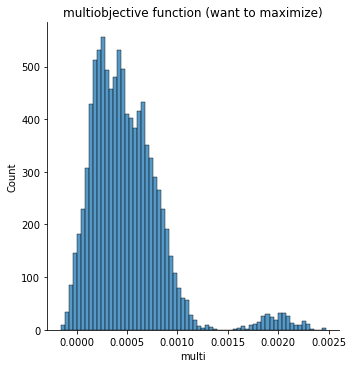

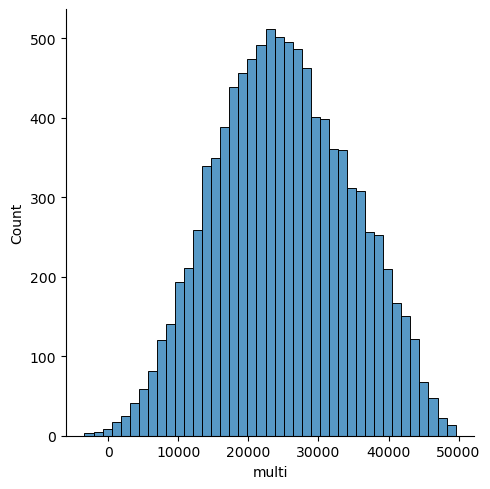

In [19]:
results_norm = optim.set_multi(results_df, all_weights)
rank_df = optim.set_multi_rank(results_norm, all_weights)

drop_results = results_norm.loc[results_norm["multi"].isnull()]
results_norm = results_norm.loc[~(results_norm["multi"].isnull())]
if len(results_norm) == 0:
    raise ValueError("No param retrieved variants")

########################
## Save the objective results
########################
results_norm.to_csv(join(outdir, "objectives_norm.csv"))

full_params.to_csv(join(outdir, "raw_params.csv"))
rank_df.to_csv(join(outdir, "objectives_rank.csv"))
#results_norm.loc[results_norm["multi"] == np.nan]
full_params.to_csv(join(outdir, "params.csv"))

########################
# Plot distribution results
########################
sns.displot(results_norm["multi"])
plt.title("multiobjective function (want to maximize)")
plt.savefig(join(outdir, "loss_multi.pdf"))

sns.displot(rank_df["multi"])


In [20]:
topn=16

In [21]:

########################
# Get the top n results
########################
def get_top_n_results(results_df, rank_df, n=12):
    filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
    filt_results = results_df.loc[filt_rank.index]
    return filt_rank, filt_results


filt_rank, filt_results = get_top_n_results(results_norm, rank_df, n=topn)
filt_results.columns = [f"{x}_obj" for x in filt_results.columns]
obj_columns = filt_results.columns
filt_results = pd.merge(filt_results, full_params_df, left_index=True, right_index=True, how="left")
filt_rank = filt_rank.loc[filt_results.index]

filt_results["params"] = filt_results.apply(params_to_str, axis=1, args=(param_names,))
filt_results["params_multi"] = filt_results.apply(params_and_multi_str, axis=1)
filt_results.head()

all_df = []
all_objs = {}
for ind, val in filt_results.iterrows():
    print(ind)
    data = evaluate_series(val, curr_af, curr_cov, True, "cv")
    df = data["binary_df"]
    #df.index = [f"{ind}_{x}" for x in df.index]
    df["ID"] = ind
    all_df.append(df)
    all_objs[ind] = data["objectives"]
all_df = pd.concat(all_df).fillna(0)
all_df.index.name = "id"
all_df.columns.name = "variant"
all_df

54079
before remove 0 filter (7002, 196)
after (4992, 33)
18215
before remove 0 filter (7002, 196)
after (7002, 69)
53767
before remove 0 filter (7002, 196)
after (7002, 36)
45083
before remove 0 filter (7002, 196)
after (6983, 36)
26919
before remove 0 filter (7002, 196)
after (7002, 73)
55303
before remove 0 filter (7002, 196)
after (7002, 34)
36123
before remove 0 filter (7002, 196)
after (6984, 39)
36139
before remove 0 filter (7002, 196)
after (6984, 39)
36119
before remove 0 filter (7002, 196)
after (7002, 39)
54027
before remove 0 filter (7002, 196)
after (6976, 33)
54043
before remove 0 filter (7002, 196)
after (6976, 33)
36159
before remove 0 filter (7002, 196)
after (5026, 38)
26939
before remove 0 filter (7002, 196)
after (6984, 71)
27163
before remove 0 filter (7002, 196)
after (6984, 54)
35879
before remove 0 filter (7002, 196)
after (7002, 50)
54135
before remove 0 filter (7002, 196)
after (7002, 34)


variant                   13188T  1438G  5581G    73G  11453A  16362C  4769G  \
id                                                                             
AAACGAACACAGCCAC-1_Flt3l   False   True  False   True   False    True  False   
AAACGAAGTCTGATTG-1_Flt3l    True   True  False  False   False   False   True   
AAACTCGAGTCTCCAA-1_Flt3l    True  False  False  False   False   False  False   
AAACTCGTCAAGGCCC-1_Flt3l   False  False  False  False   False   False  False   
AAACTCGTCTTACGGA-1_Flt3l   False  False  False  False   False   False  False   
...                          ...    ...    ...    ...     ...     ...    ...   
TTTGTGTGTAGGGTCA-1_Input    True   True  False   True   False    True   True   
TTTGTGTGTTTCTTAC-1_Input    True   True  False   True   False    True   True   
TTTGTGTTCCTGAAAC-1_Input    True   True  False   True   False    True   True   
TTTGTGTTCGGGAAAC-1_Input    True   True  False   True   False    True   True   
TTTGTGTTCTGGCACG-1_Input    True   True   True   True   False    True   True   

variant                   8292A  7028T  14766T  ...  189G  16129A  310C  \
id                                              ...                       
AAACGAACACAGCCAC-1_Flt3l   True  False    True  ...     0       0     0   
AAACGAAGTCTGATTG-1_Flt3l   True   True    True  ...     0       0     0   
AAACTCGAGTCTCCAA-1_Flt3l  False  False    True  ...     0       0     0   
AAACTCGTCAAGGCCC-1_Flt3l  False  False   False  ...     0       0     0   
AAACTCGTCTTACGGA-1_Flt3l  False  False   False  ...     0       0     0   
...                         ...    ...     ...  ...   ...     ...   ...   
TTTGTGTGTAGGGTCA-1_Input   True   True    True  ...     0   False     0   
TTTGTGTGTTTCTTAC-1_Input   True   True    True  ...     0   False     0   
TTTGTGTTCCTGAAAC-1_Input   True   True    True  ...     0   False     0   
TTTGTGTTCGGGAAAC-1_Input   True   True    True  ...     0   False     0   
TTTGTGTTCTGGCACG-1_Input   True   True    True  ...     0   False     0   

variant                   15607G  2833G  14905A  10953C  2445C  16172C  13676G  
id                                                                              
AAACGAACACAGCCAC-1_Flt3l       0      0       0       0      0       0       0  
AAACGAAGTCTGATTG-1_Flt3l       0      0       0       0      0       0       0  
AAACTCGAGTCTCCAA-1_Flt3l       0      0       0       0      0       0       0  
AAACTCGTCAAGGCCC-1_Flt3l       0      0       0       0      0       0       0  
AAACTCGTCTTACGGA-1_Flt3l       0      0       0       0      0       0       0  
...                          ...    ...     ...     ...    ...     ...     ...  
TTTGTGTGTAGGGTCA-1_Input       0      0       0       0      0       0       0  
TTTGTGTGTTTCTTAC-1_Input       0      0       0       0      0       0       0  
TTTGTGTTCCTGAAAC-1_Input       0      0       0       0      0       0       0  
TTTGTGTTCGGGAAAC-1_Input       0      0       0       0      0       0       0  
TTTGTGTTCTGGCACG-1_Input       0      0       0       0      0       0       0  

[107903 rows x 74 columns]

In [22]:
filt_results

n_cells_obs_obj  n_vars_obs_obj   cov_obj  oth_cov_obj    af_obj  \
54079         0.000081        0.000088  0.000256     0.000255  0.000250   
18215         0.000114        0.000184  0.000043     0.000255  0.000042   
53767         0.000114        0.000096  0.000043     0.000255  0.000250   
45083         0.000113        0.000096  0.000085     0.000255  0.000210   
26919         0.000114        0.000195  0.000043     0.000255  0.000066   
55303         0.000114        0.000091  0.000043     0.000255  0.000250   
36123         0.000113        0.000104  0.000085     0.000255  0.000105   
36139         0.000113        0.000104  0.000085     0.000255  0.000105   
36119         0.000114        0.000104  0.000043     0.000255  0.000105   
54027         0.000113        0.000088  0.000085     0.000255  0.000250   
54043         0.000113        0.000088  0.000085     0.000255  0.000250   
36159         0.000082        0.000101  0.000256     0.000255  0.000105   
26939         0.000113        0.000189  0.000085     0.000255  0.000066   
27163         0.000113        0.000144  0.000085     0.000255  0.000066   
35879         0.000114        0.000133  0.000043     0.000255  0.000105   
54135         0.000114        0.000091  0.000043     0.000255  0.000250   

       oth_af_obj  ncells_obj  oth_ncells_obj    cv_obj  multi_obj    af  \
54079    0.000003    0.000319        0.000057  0.000079   0.001269  0.95   
18215    0.000003    0.000319        0.000057  0.000271   0.001168  0.16   
53767    0.000003    0.000160        0.000057  0.000069   0.000926  0.95   
45083    0.000003    0.000319        0.000057  0.000079   0.001099  0.80   
26919    0.000003    0.000160        0.000057  0.000299   0.001071  0.25   
55303    0.000026    0.000319        0.000057  0.000056   0.001044  0.95   
36123    0.000003    0.000319        0.000057  0.000097   0.001020  0.40   
36139    0.000003    0.000319        0.000057  0.000097   0.001020  0.40   
36119    0.000003    0.000319        0.000057  0.000076   0.000956  0.40   
54027    0.000003    0.000319        0.000057  0.000068   0.001120  0.95   
54043    0.000003    0.000319        0.000057  0.000068   0.001120  0.95   
36159    0.000003    0.000319        0.000057  0.000106   0.001165  0.40   
26939    0.000003    0.000160        0.000057  0.000308   0.001116  0.25   
27163    0.000003    0.000319        0.000057  0.000196   0.001119  0.25   
35879    0.000003    0.000160        0.000057  0.000148   0.000898  0.40   
54135    0.000003    0.000319        0.000076  0.000056   0.001048  0.95   

       oth_af  ncells  oth_ncells  mean_cov  cov  oth_cov  \
54079    0.01    10.0         0.3        10   30       30   
18215    0.01    10.0         0.3         5    5       30   
53767    0.01     5.0         0.3         0    5       30   
45083    0.01    10.0         0.3         2   10       30   
26919    0.01     5.0         0.3         5    5       30   
55303    0.10    10.0         0.3         0    5       30   
36123    0.01    10.0         0.3         2   10       30   
36139    0.01    10.0         0.3         5   10       30   
36119    0.01    10.0         0.3         2    5       30   
54027    0.01    10.0         0.3         0   10       30   
54043    0.01    10.0         0.3         2   10       30   
36159    0.01    10.0         0.3        10   30       30   
26939    0.01     5.0         0.3        10   10       30   
27163    0.01    10.0         0.3         2   10       30   
35879    0.01     5.0         0.3         5    5       30   
54135    0.01    10.0         0.4        10    5       30   

                                                  params  \
54079  af=0.9500\noth_af=0.0100\nncells=10.0000\noth_...   
18215  af=0.1600\noth_af=0.0100\nncells=10.0000\noth_...   
53767  af=0.9500\noth_af=0.0100\nncells=5.0000\noth_n...   
45083  af=0.8000\noth_af=0.0100\nncells=10.0000\noth_...   
26919  af=0.2500\noth_af=0.0100\nncells=5.0000\noth_n...   
55303  af=0.9500\noth_af=0.1000\nncells=

In [23]:
row_clr_schemes = {p:"categorical" for p in param_names}
for o in obj_columns:
    row_clr_schemes[o] = "sequential"
row_clr_schemes


{'af': 'categorical',
 'oth_af': 'categorical',
 'ncells': 'categorical',
 'oth_ncells': 'categorical',
 'mean_cov': 'categorical',
 'cov': 'categorical',
 'oth_cov': 'categorical',
 'n_cells_obs_obj': 'sequential',
 'n_vars_obs_obj': 'sequential',
 'cov_obj': 'sequential',
 'oth_cov_obj': 'sequential',
 'af_obj': 'sequential',
 'oth_af_obj': 'sequential',
 'ncells_obj': 'sequential',
 'oth_ncells_obj': 'sequential',
 'cv_obj': 'sequential',
 'multi_obj': 'sequential'}

In [24]:
val

n_cells_obs_obj                                             0.000114
n_vars_obs_obj                                              0.000091
cov_obj                                                     0.000043
oth_cov_obj                                                 0.000255
af_obj                                                       0.00025
oth_af_obj                                                  0.000003
ncells_obj                                                  0.000319
oth_ncells_obj                                              0.000076
cv_obj                                                      0.000056
multi_obj                                                   0.001048
af                                                              0.95
oth_af                                                          0.01
ncells                                                          10.0
oth_ncells                                                       0.4
mean_cov                          

In [26]:
import sys
sys.setrecursionlimit(1000000)


ind 18215
(7002, 70)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ind 26919
(7002, 74)
ind 26939
(6984, 72)
ind 27163
(6984, 55)
ind 35879
(7002, 51)
ind 36119
(7002, 40)
ind 36123
(6984, 40)
ind 36139
(6984, 40)
ind 36159
(5026, 39)
ind 45083
(6983, 37)
ind 53767
(7002, 37)
ind 54027
(6976, 34)
ind 54043
(6976, 34)
ind 54079
(4992, 34)
ind 54135
(7002, 35)
ind 55303
(7002, 35)


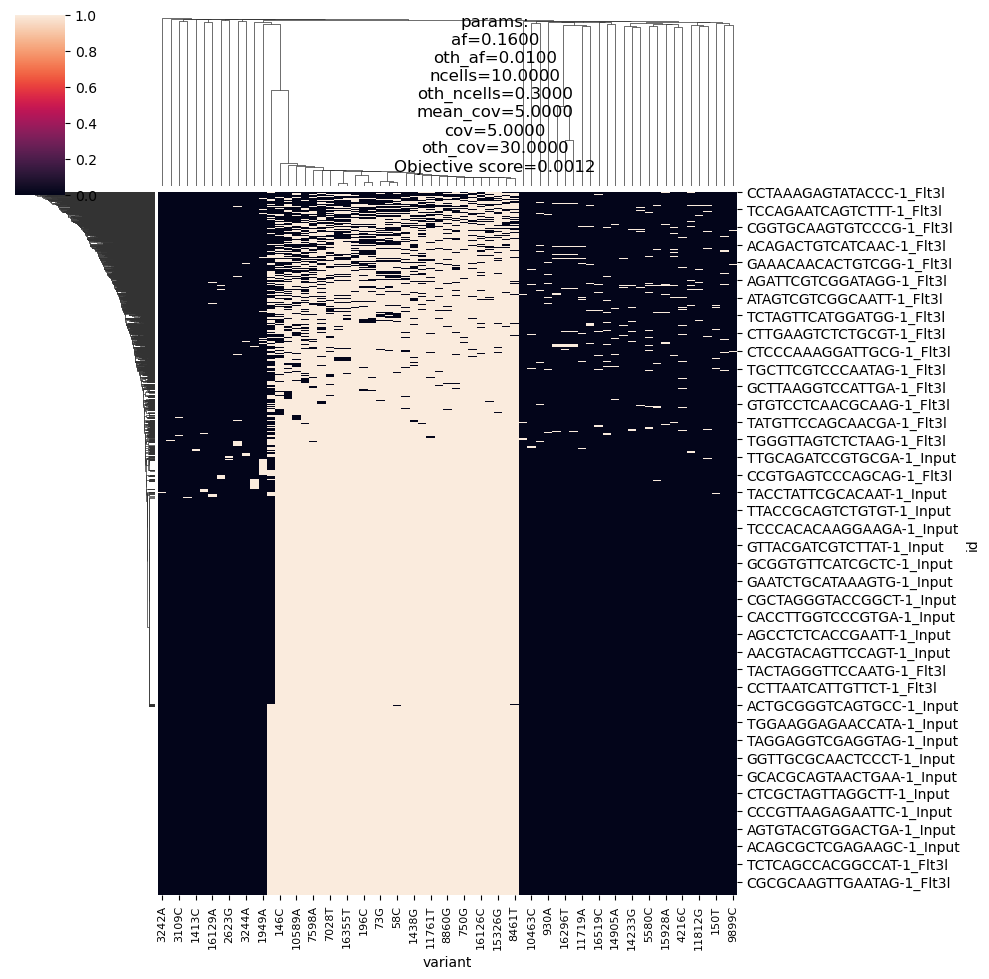

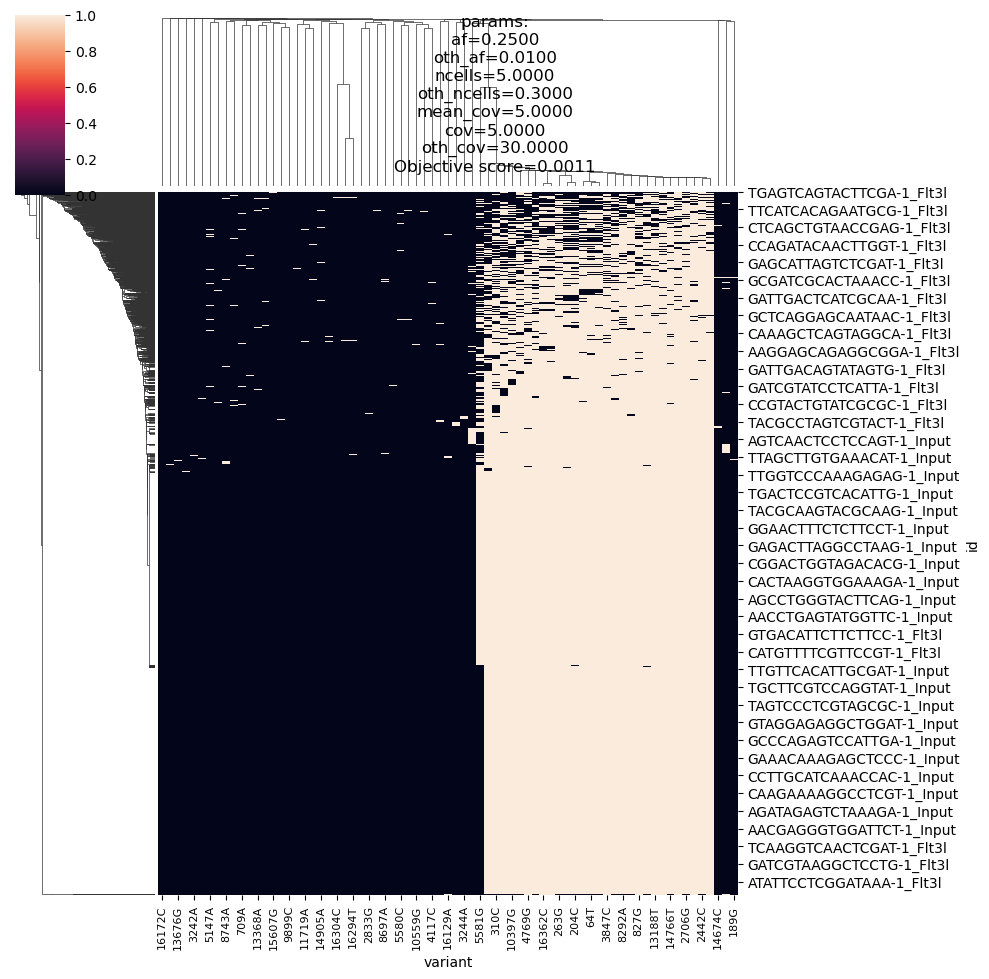

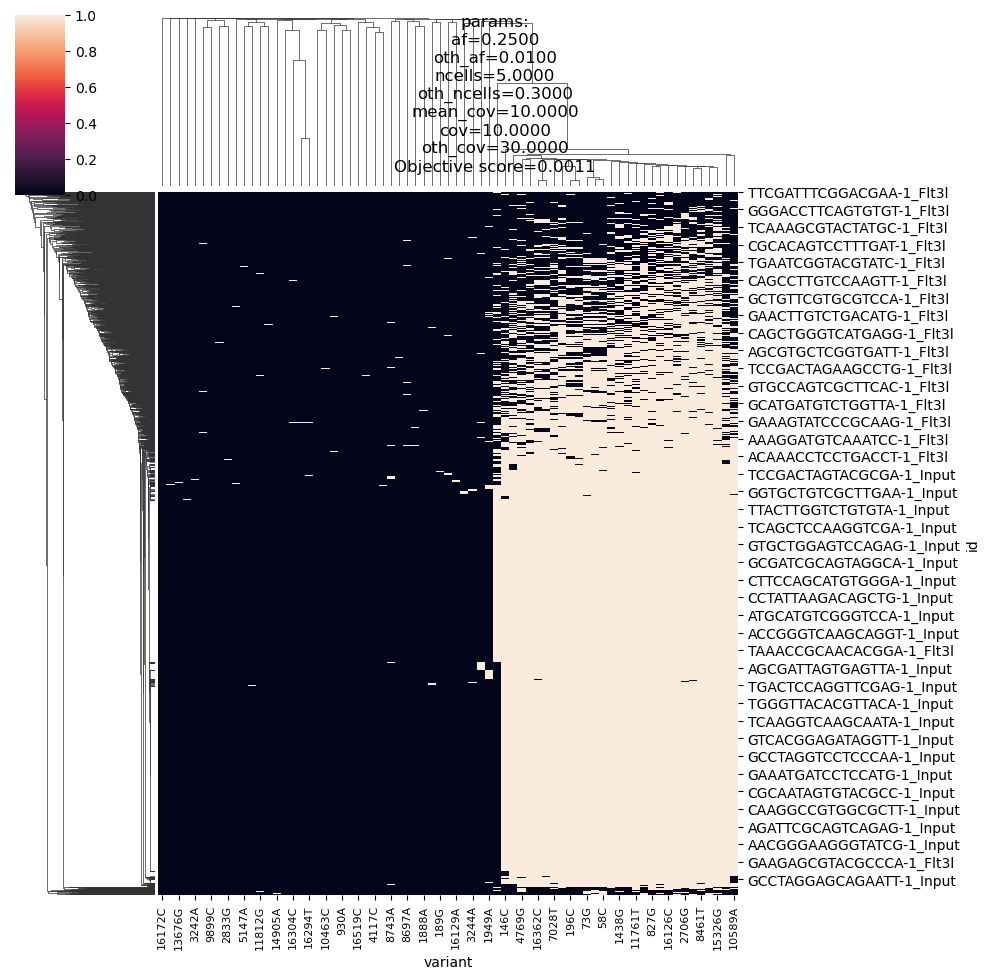

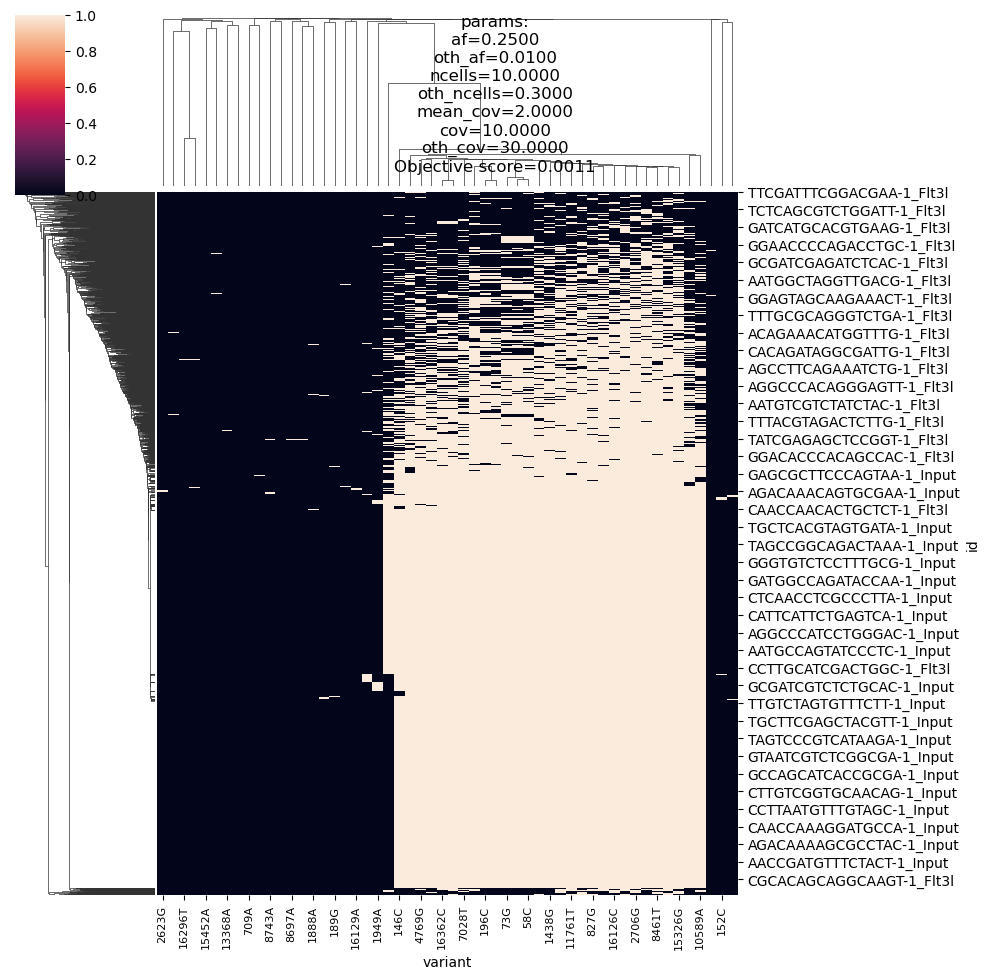

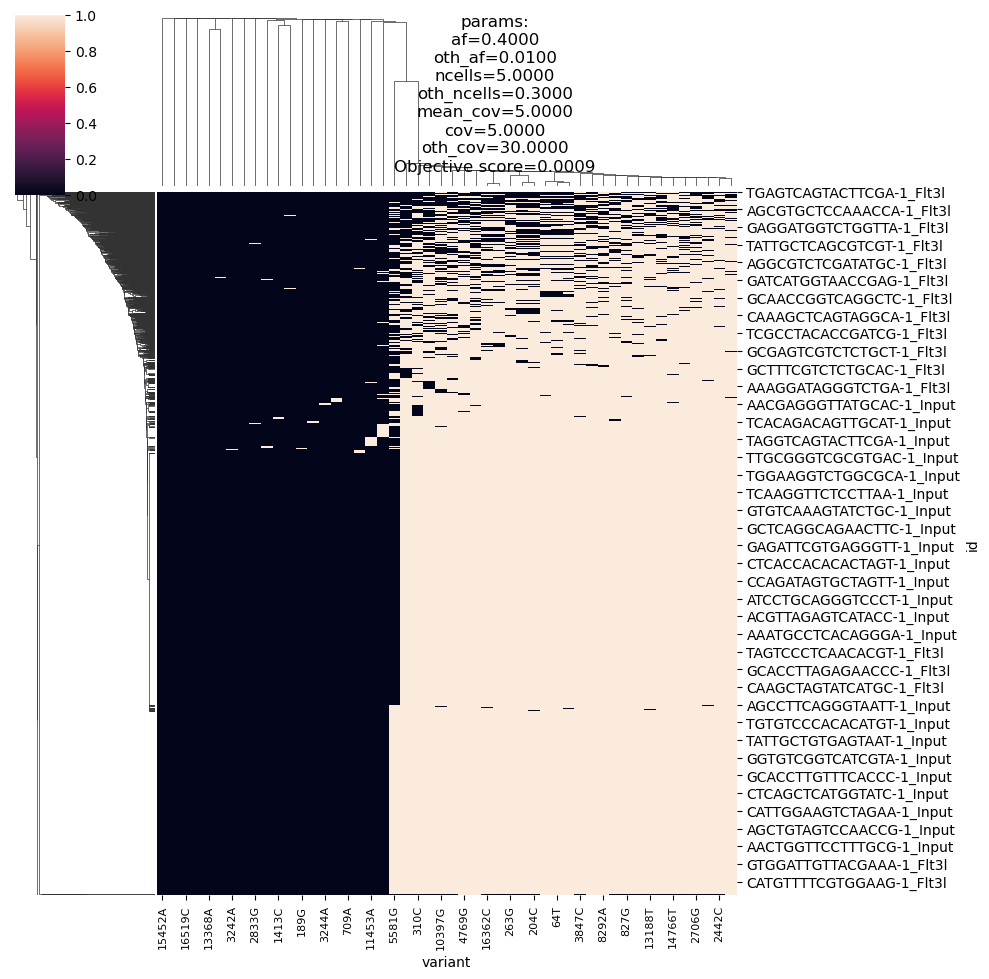

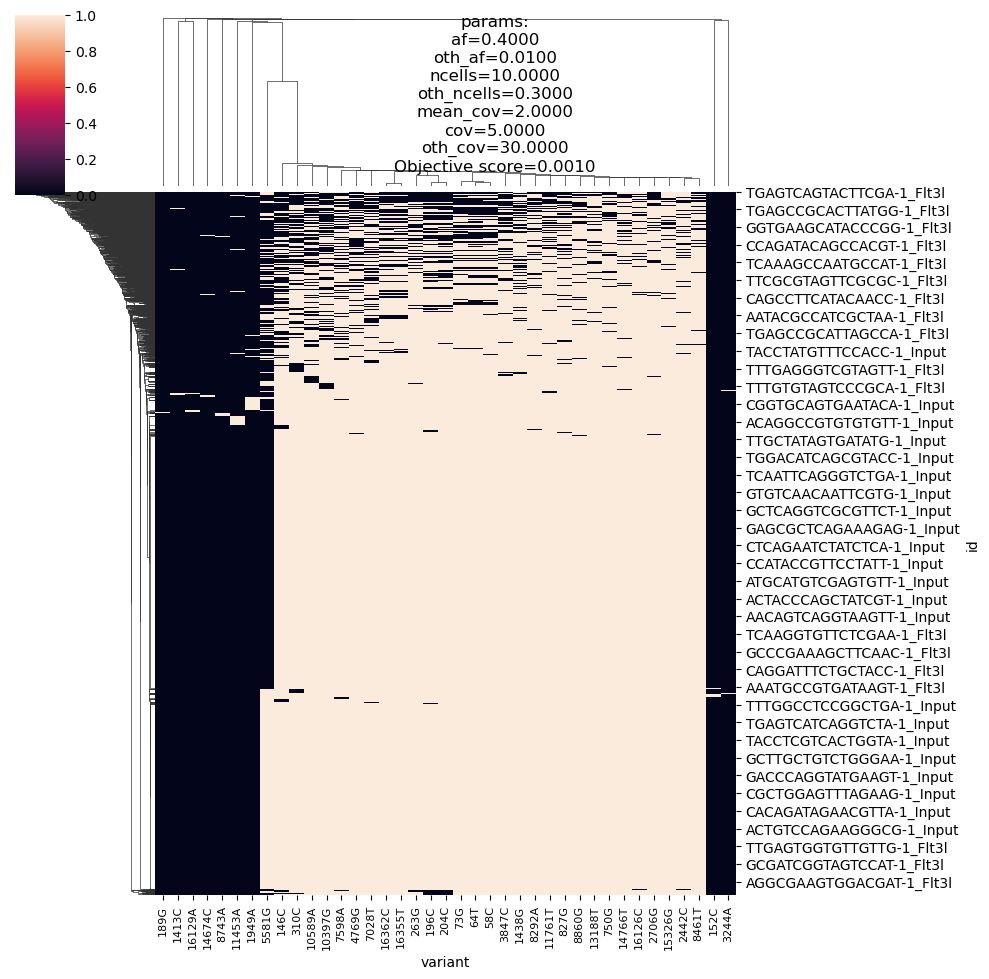

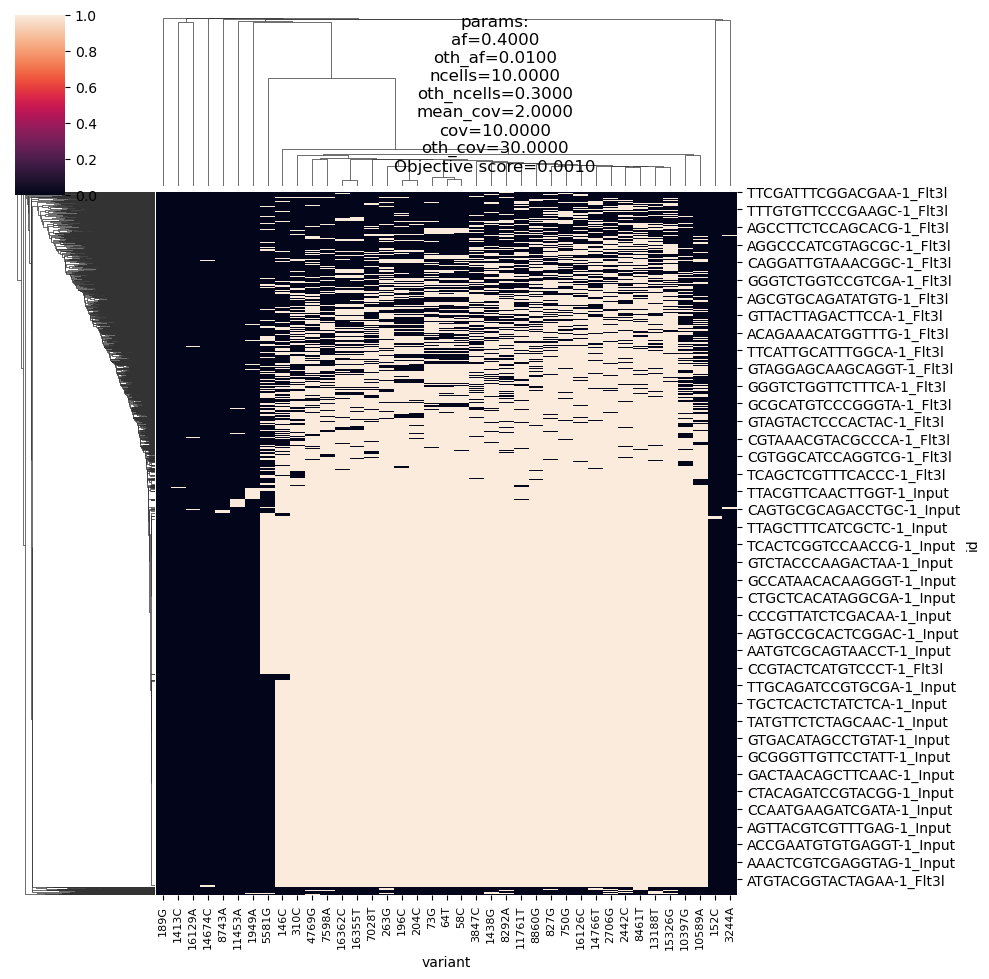

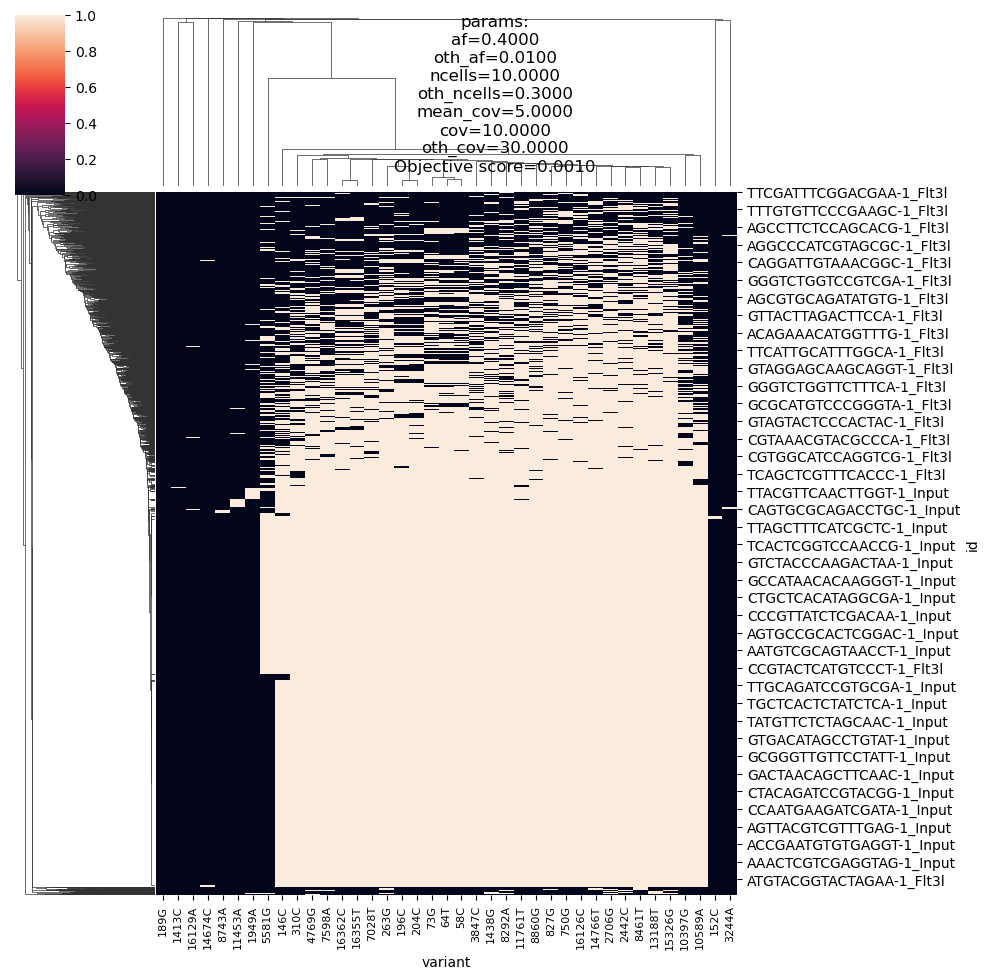

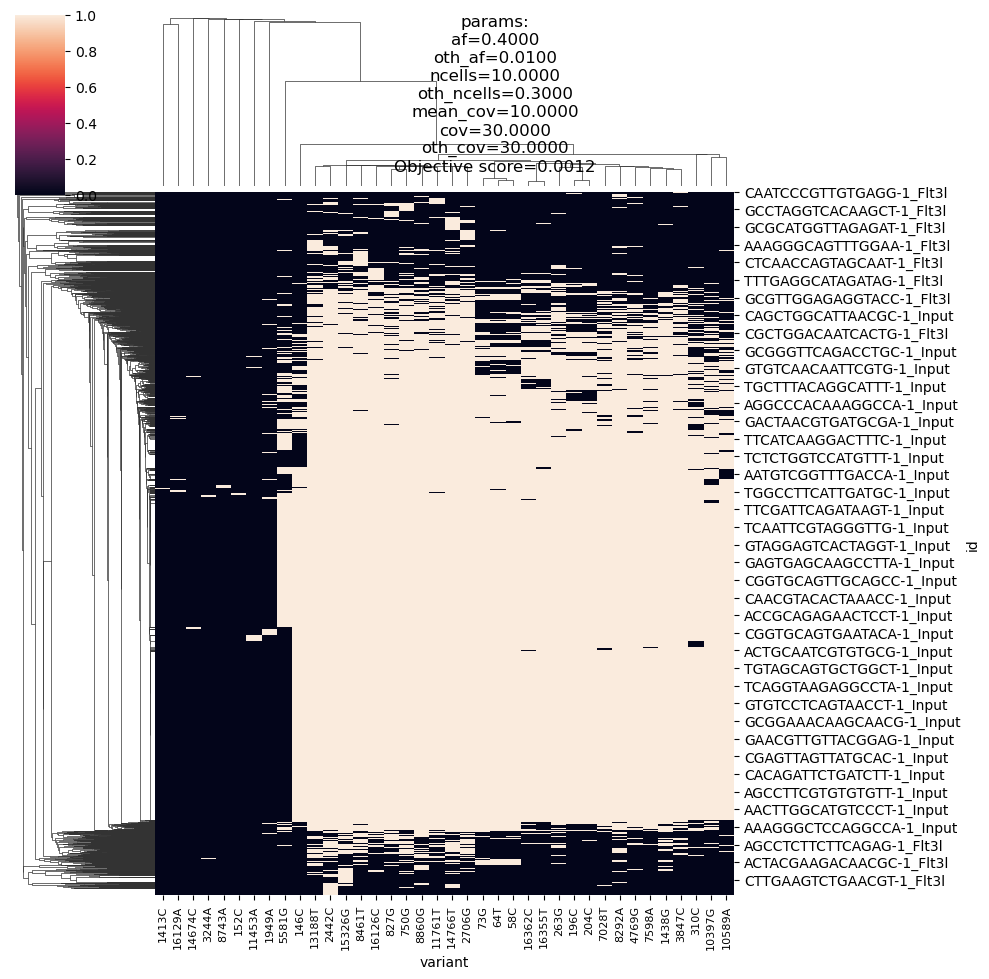

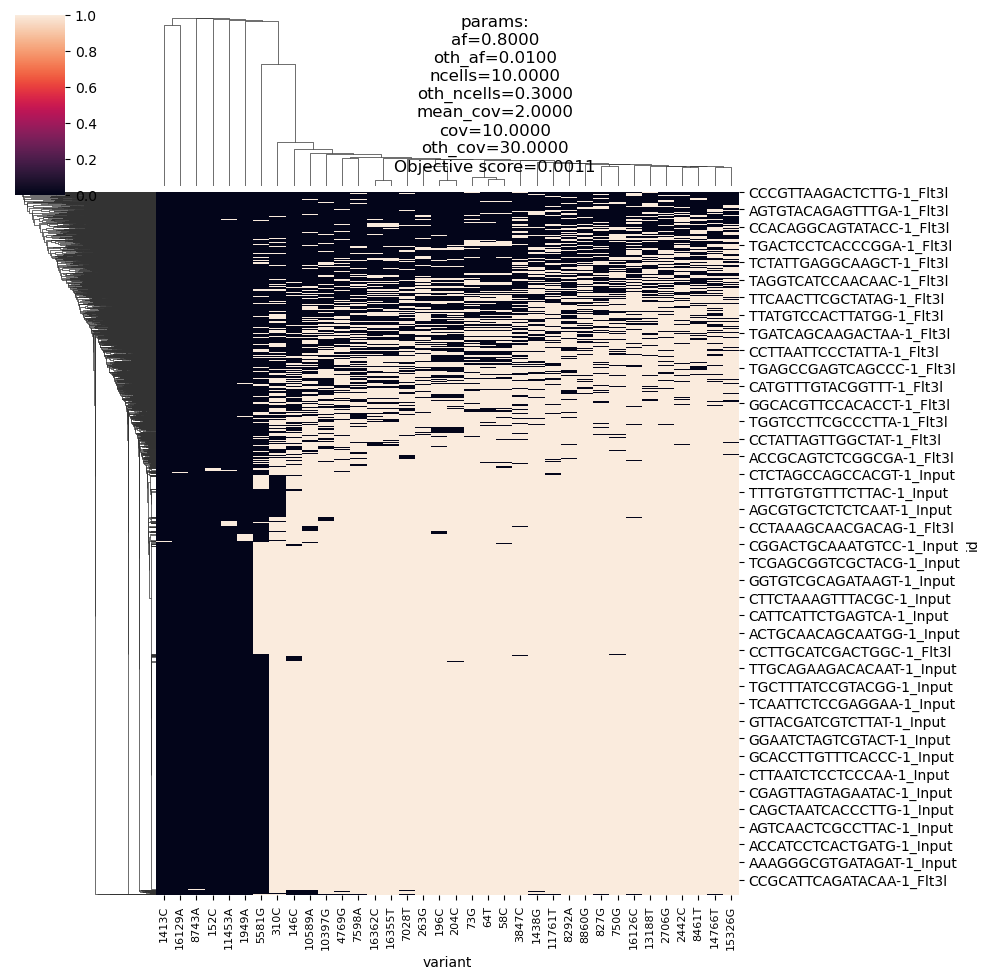

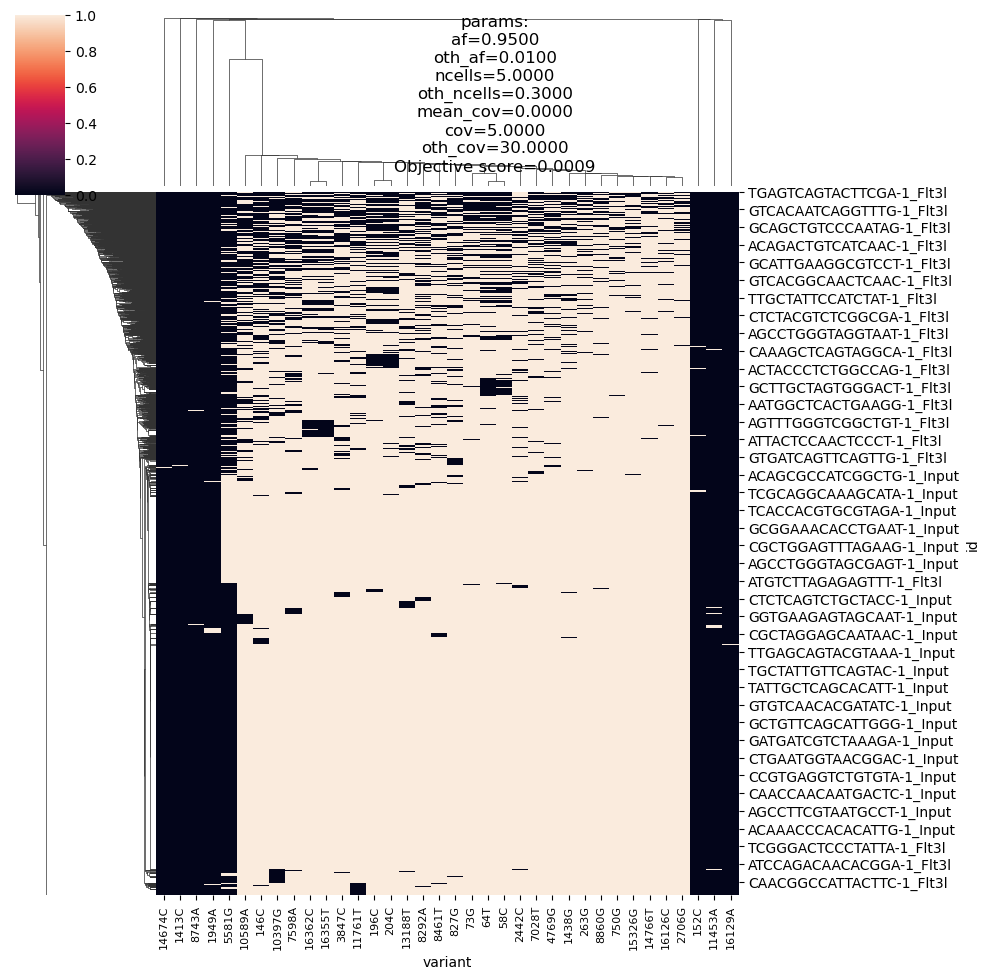

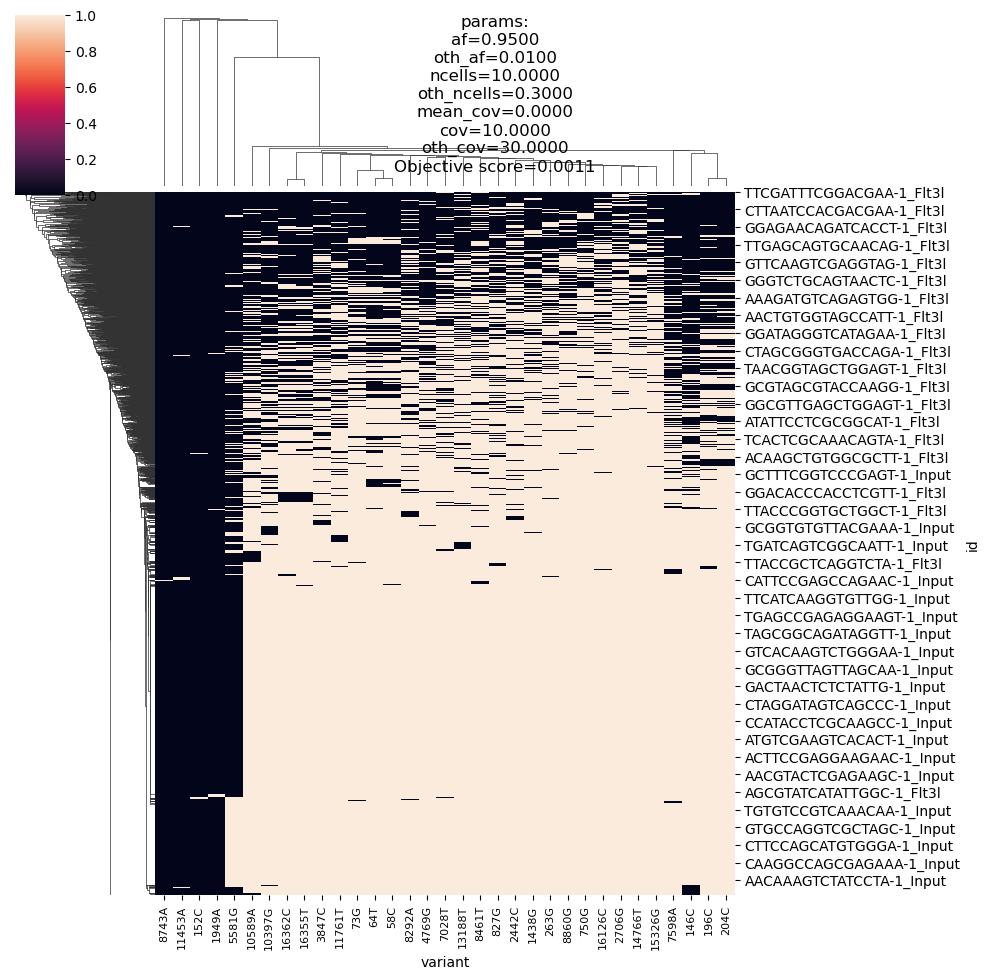

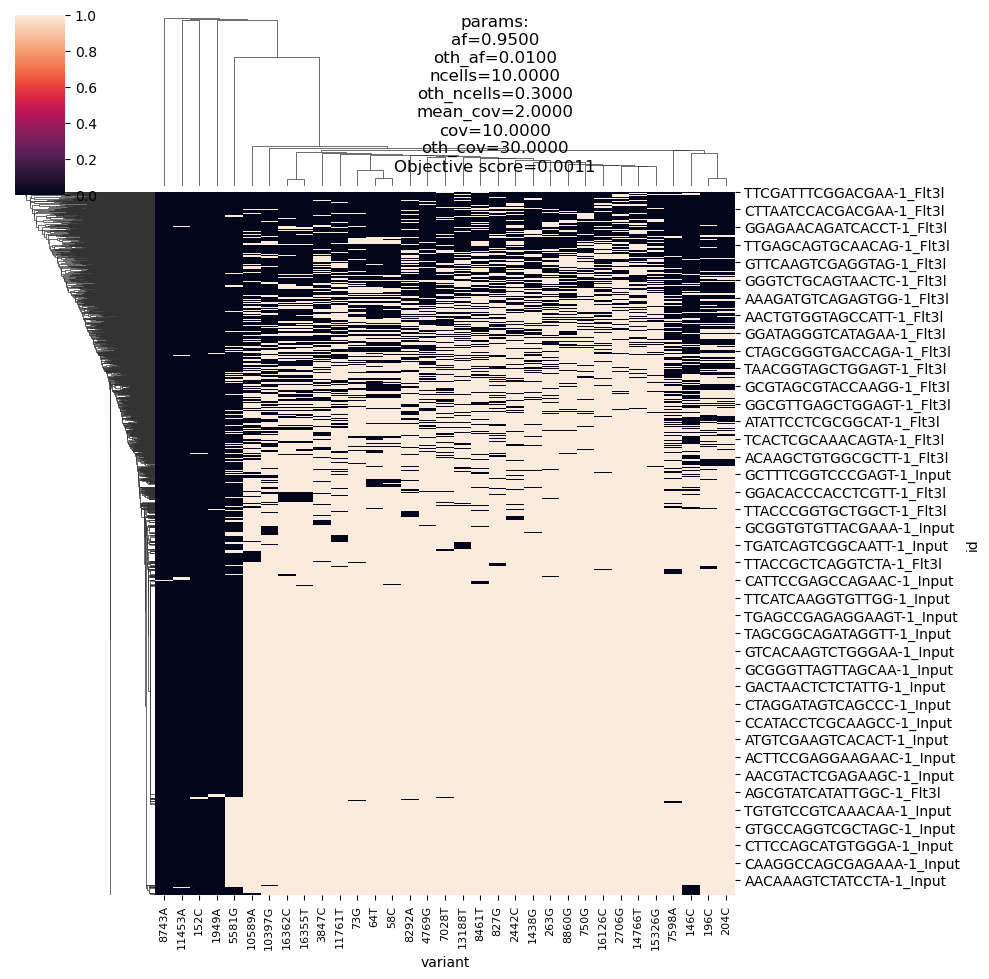

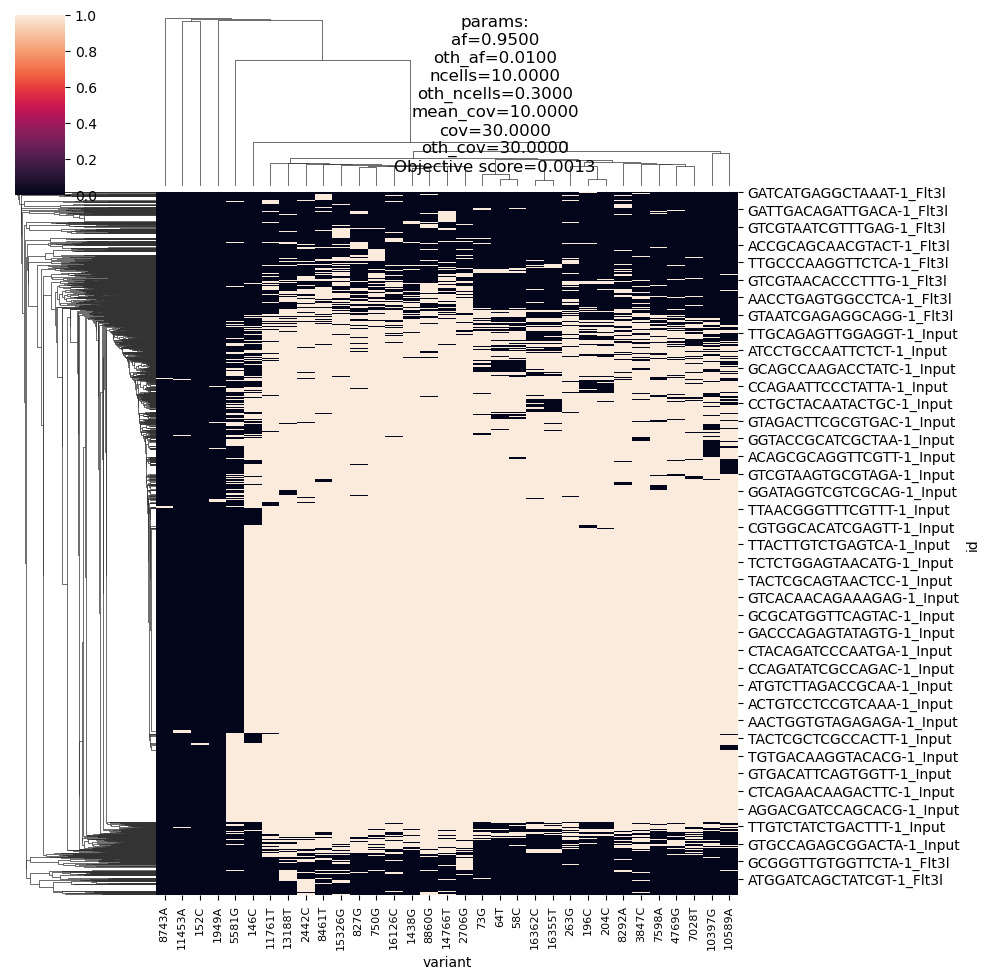

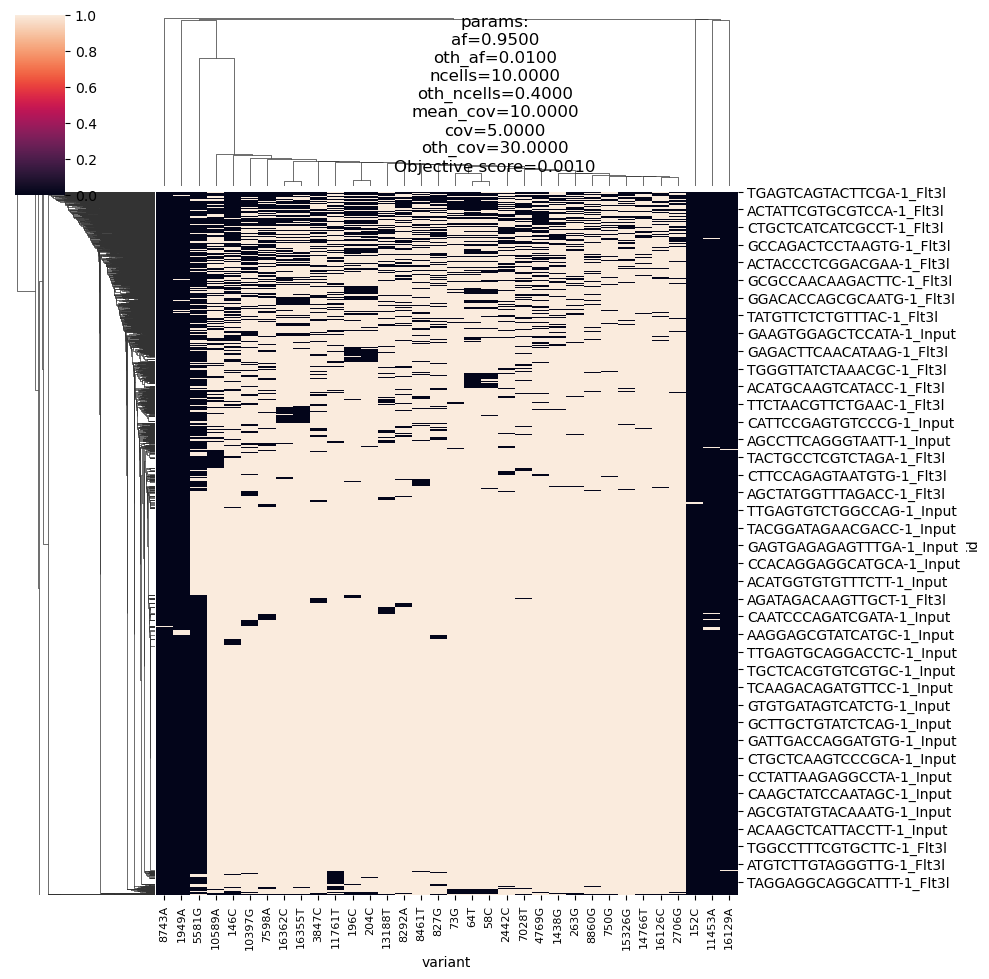

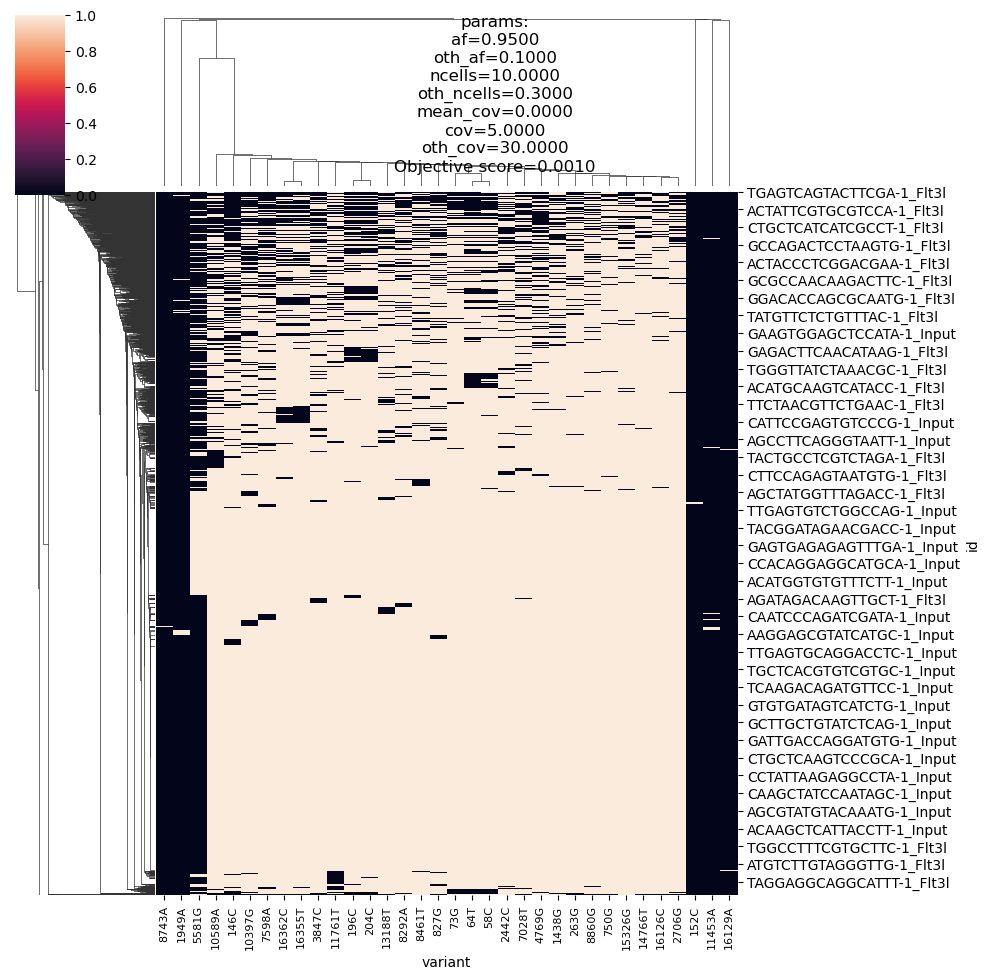

In [27]:
for ind, val in all_df.groupby("ID"):
    print('ind', ind)
    val = val.fillna(0).loc[~(val == 0).all(axis=1)].loc[:, ~(val == 0).all()]
    print(val.shape)
    meta_df = val.apply(lambda x: filt_results.loc[ind], axis=1, result_type='expand')
    g = ch.plot_cluster(df=val.drop("ID", axis=1).fillna(0).astype(int), 
                        to_row_clust=True, to_col_clust=True,
                        metric='jaccard')
    g.fig.suptitle(filt_results.loc[ind, "params_multi"])

In [28]:
# clusters, link = create_dendro(val, minClusterSize=3)
# clusters.unique()

distances
[0.2        0.52       0.4        ... 0.03448276 0.03333333 0.06666667]
link
[[1.90600000e+03 2.15100000e+03 0.00000000e+00 2.00000000e+00]
 [4.88400000e+03 7.00200000e+03 0.00000000e+00 3.00000000e+00]
 [6.29400000e+03 7.00300000e+03 0.00000000e+00 4.00000000e+00]
 ...
 [1.39720000e+04 1.39840000e+04 7.23295778e-01 8.00000000e+00]
 [1.39990000e+04 1.40000000e+04 7.58164071e-01 7.00100000e+03]
 [2.90500000e+03 1.40010000e+04 8.61227411e-01 7.00200000e+03]]
deepsplit 1
..cutHeight not given, setting it to 0.8526151366721516  ===>  99% of the (truncated) height range in dendro.


KeyboardInterrupt: 

----